# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,num_iters=1500, verbose = True)
        y_train_pred = svm.predict(X_train_feats)
        y_train_Acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        y_val_Acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (y_train_Acc, y_val_Acc)
        if (y_val_Acc > best_val):
            best_val = y_val_Acc
            best_svm = svm



################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 47.379991
iteration 100 / 1500: loss 46.993337
iteration 200 / 1500: loss 46.629710
iteration 300 / 1500: loss 46.234266
iteration 400 / 1500: loss 45.873536
iteration 500 / 1500: loss 45.505282
iteration 600 / 1500: loss 45.129655
iteration 700 / 1500: loss 44.768493
iteration 800 / 1500: loss 44.403032
iteration 900 / 1500: loss 44.067828
iteration 1000 / 1500: loss 43.724891
iteration 1100 / 1500: loss 43.363152
iteration 1200 / 1500: loss 43.035154
iteration 1300 / 1500: loss 42.694031
iteration 1400 / 1500: loss 42.345781
iteration 0 / 1500: loss 395.802904
iteration 100 / 1500: loss 358.984794
iteration 200 / 1500: loss 325.670309
iteration 300 / 1500: loss 295.519848
iteration 400 / 1500: loss 268.253977
iteration 500 / 1500: loss 243.587621
iteration 600 / 1500: loss 221.244808
iteration 700 / 1500: loss 201.049467
iteration 800 / 1500: loss 182.764244
iteration 900 / 1500: loss 166.217751
iteration 1000 / 1500: loss 151.259064
iteration 1100 / 1500: lo

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.41


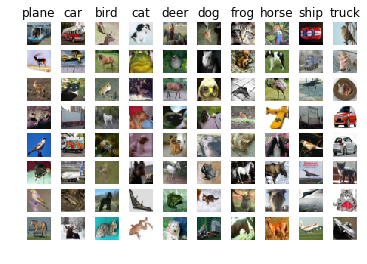

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [16]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val_acc = -1
best_net = None

num_iters=1500
batch_size=300
learning_rate_decay=0.95
hypter_regularization_strengths = [5e-4, 1e-3, 5e-3, 1e-2]
hypter_learning_rates = [1e-1, 5e-1, 1, 3]

for reg in hypter_regularization_strengths:
    print('reg(%.2e): ' % reg, end=' ')
    for lr in hypter_learning_rates:
        print('<%.2e>' % lr, end=' ')
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=num_iters, batch_size=batch_size,
        learning_rate=lr, learning_rate_decay=learning_rate_decay,
        reg= reg, verbose=False)
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        if val_acc > best_val:
            best_val_acc = val_acc
            best_net = net         
        results[(reg,lr)] = val_acc
    print()

print()
# Print out results.
for reg, lr in sorted(results):
    val_acc = results[(reg, lr)]
    print('reg %.2e| lr %.2e|---> val accuracy: %f' % (reg, lr,  val_acc))

print()
print('Best validation accuracy achieved: %f' % best_val_acc)
print('With hypterparametser (reg, lr): ', list(results.keys())[list(results.values()).index(best_val_acc)])
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

reg(5.00e-04):  <1.00e-01> <5.00e-01> <1.00e+00> 
reg(1.00e-03):  <1.00e-01> <5.00e-01> <1.00e+00> 
reg(5.00e-03):  <1.00e-01> <5.00e-01> <1.00e+00> 
reg(1.00e-02):  <1.00e-01> <5.00e-01> <1.00e+00> 
lr 1.00e-01| reg 5.00e-04|---> val accuracy: 0.537000
lr 1.00e-01| reg 1.00e-03|---> val accuracy: 0.540000
lr 1.00e-01| reg 5.00e-03|---> val accuracy: 0.516000
lr 1.00e-01| reg 1.00e-02|---> val accuracy: 0.508000
lr 5.00e-01| reg 5.00e-04|---> val accuracy: 0.583000
lr 5.00e-01| reg 1.00e-03|---> val accuracy: 0.590000
lr 5.00e-01| reg 5.00e-03|---> val accuracy: 0.541000
lr 5.00e-01| reg 1.00e-02|---> val accuracy: 0.504000
lr 1.00e+00| reg 5.00e-04|---> val accuracy: 0.568000
lr 1.00e+00| reg 1.00e-03|---> val accuracy: 0.595000
lr 1.00e+00| reg 5.00e-03|---> val accuracy: 0.512000
lr 1.00e+00| reg 1.00e-02|---> val accuracy: 0.529000
Best validation accuracy achieved: 0.595000
With hypterparametser (lr, reg):  (1, 0.001)


In [17]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.584
